# Sequence Processing with Recurrent Neural Networks

# <font color="red">Contributions</font>

- Panagiotis Ioannis Dallas
- Ioanna Vounzoulaki

Both of us contributed equally in this project.

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors.

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs.
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing.

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [ ]:
import numpy as np
import torch
print(f"torch ver={torch.__version__}\nnumpy ver={np.__version__}")
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional
torch.set_printoptions(precision=8) #to increase precision of printing floats

torch ver=2.1.0+cu118
numpy ver=1.23.5


We will use the following function to concisely convert torch tensors to numpy arrays before printing tensors.

In [ ]:
def tr2np(tensor):
    """Convert torch tensor into numpy array"""
    return tensor.detach().numpy()

### Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

<font color="red">_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [ ]:
# @title c1 [.5pt]
class mySRN(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        # setting x to h with no Bias while h to h and h to y both have
        self.x_to_h = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True)
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    # Computational step function based on the description
    def step(self, x: FloatTensor, h: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        ht = self.hidden_activation(self.x_to_h(x) + self.h_to_h(h))
        yt = self.output_activation(self.h_to_y(ht))
        return ht, yt

    def forward(self, X: List[FloatTensor], h: FloatTensor) -> List[FloatTensor]:
        Y = []
        ht = h
        # Iterate through X and append the output to Y
        for i in range(len(X)):
            ht, yt = self.step(X[i], ht)
            Y.append(yt)
        return Y

The following toy RNN helps you to verify whether your implementation is correct.  
Use the numbers below in the functions, and you can manually verify the output of the RNN.  
This manual check will help you to see whether you are understanding the calculations behind the RNN.

In [ ]:
# TEST c1
# let's use seed so that the weights are initialized in a deterministic way
torch.manual_seed(10)
# create our RNN with some short dimensions
my_rnn = mySRN(3, 2, 1, torch.nn.ReLU(), torch.nn.ReLU(), 'cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(my_rnn.x_to_h.weight), "\nbias:", my_rnn.x_to_h.bias)
print("H->H", "\nmatrix:\n", tr2np(my_rnn.h_to_h.weight), "\nbias:", tr2np(my_rnn.h_to_h.bias))
print("H->Y", "\nmatrix:\n", tr2np(my_rnn.h_to_y.weight), "\nbias:", tr2np(my_rnn.h_to_y.bias))

# running the RNN on a sample input of size 2 and an initial hidden vector
output = my_rnn.forward([FloatTensor([0,0,1]), FloatTensor([1,0,0])],
                         FloatTensor([1,1]))

print("output:\n", output)

X->H 
matrix:
 [[-0.04839968 -0.01979553 -0.21650827]
 [ 0.13281555 -0.33030522 -0.10181434]] 
bias: None
H->H 
matrix:
 [[ 0.27406603  0.6637026 ]
 [ 0.16658802 -0.23989876]] 
bias: [ 0.06780045 -0.07924712]
H->Y 
matrix:
 [[0.28863114 0.0809646 ]] 
bias: [0.2769911]
output:
 [tensor([0.50473863], grad_fn=<ReluBackward0>), tensor([0.35998842], grad_fn=<ReluBackward0>)]


In practice, we do not need to write our own functions for common RNN architectures.
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

**Read the documentation (!) for further details.**

A brief example is given below.

In [ ]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [ ]:
del mySRN, rnn, X, h, my_rnn, output

### A faster version of the SRN
Now let's wrap an `RNN` into a custom module `fastSRN` that implements it along with the `h_to_y` transformation.

In [ ]:
# @title c2 [.5pt]
class fastSRN(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: str,
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        # temporary object of the superclass
        super(fastSRN, self).__init__()
        # Access variables of the current instance
        self.rnn = torch.nn.RNN(input_size = input_dim, hidden_size = hidden_dim, nonlinearity = hidden_activation , bidirectional = False, dropout = 0)
        # h to y has to be initiallized once with the configured dimensions
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.output_activation = output_activation
        self.device = device

    def forward(self, X:FloatTensor, h: Optional[FloatTensor]=None) -> FloatTensor:
        h_tran , _ = self.rnn(X, h)
        y_transformed = self.h_to_y(h_tran)
        output = self.output_activation(y_transformed)
        return output

Let's see our new implementation in action.

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [ ]:
# TEST c2a
fast_srn = fastSRN(
    input_dim=16, hidden_dim=42, output_dim=2,
    hidden_activation="tanh", output_activation=torch.nn.Softmax(dim=-1), device="cpu"
)
X = torch.rand(10, 32, 16)
y = fast_srn(X)
y.shape

torch.Size([10, 32, 2])

Again you can verify correctness of your implementation here, and as before, check whether it really does the computations what equations are describing.

In [ ]:
# TEST c2b
torch.manual_seed(10)
# create our RNN with some short dimensions
fast_srn = fastSRN(3, 2, 2, 'relu', output_activation=torch.nn.Softmax(dim=-1), device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_ih_l0), "\nbias:",  tr2np(fast_srn.rnn.bias_ih_l0))
print("H->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_hh_l0), "\nbias:", tr2np(fast_srn.rnn.bias_hh_l0))
print("H->Y", "\nmatrix:\n", tr2np(fast_srn.h_to_y.weight), "\nbias:", tr2np(fast_srn.h_to_y.bias))


# running the RNN on a sample input of size 2
output = fast_srn.forward(torch.FloatTensor([[[0,0,1]], [[1,0,0]]]))

print("output:\n", tr2np(output))

X->H 
matrix:
 [[-0.05927727 -0.02424447 -0.2651674 ]
 [ 0.16266517 -0.40453961 -0.12469659]] 
bias: [ 0.06780045 -0.07924712]
H->H 
matrix:
 [[ 0.27406603  0.6637026 ]
 [ 0.16658802 -0.23989876]] 
bias: [0.28863114 0.0809646 ]
H->Y 
matrix:
 [[ 0.2769911   0.6857927 ]
 [-0.29362798 -0.02499055]] 
bias: [ 0.16262412 -0.00461879]
output:
 [[[0.55461127 0.44538873]]

 [[0.61744654 0.3825534 ]]]


In [ ]:
del fast_srn, X, y, output

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [ ]:
x1 = torch.rand(1, 3)  # a sequence of 1, 3-dimensional item
x2 = torch.rand(4, 3)  # a sequence of 4, 3-dimensional items
x3 = torch.rand(2, 3)  # a sequence of 2, 3-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x1, x2, x3])

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([4, 3, 3])


Now compare the contents for better understanding.

In [ ]:
for i in [x1, x2, x3]: print(i)
print(f"{'':=^50}\n{X}")

tensor([[0.45211244, 0.05751723, 0.06869602]])
tensor([[0.05007005, 0.01075643, 0.03432530],
        [0.12121904, 0.04903173, 0.03096646],
        [0.71918452, 0.80667484, 0.83786207],
        [0.76936007, 0.66942430, 0.72027290]])
tensor([[0.22349077, 0.95017546, 0.46551836],
        [0.93140107, 0.65328628, 0.89135820]])
tensor([[[0.45211244, 0.05751723, 0.06869602],
         [0.05007005, 0.01075643, 0.03432530],
         [0.22349077, 0.95017546, 0.46551836]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.12121904, 0.04903173, 0.03096646],
         [0.93140107, 0.65328628, 0.89135820]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.71918452, 0.80667484, 0.83786207],
         [0.00000000, 0.00000000, 0.00000000]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.76936007, 0.66942430, 0.72027290],
         [0.00000000, 0.00000000, 0.00000000]]])


In [ ]:
del x1, x2, x3, X

## Pretrained Word Embeddings
Moving on --- in the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

<s>Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).</s>  
Fortunately the Colab environment comes with SapCy.

In [ ]:
import spacy
print(f"spacy ver={spacy.__version__}")

spacy ver=3.6.1


SpaCy comes with a lot of different-size models for different languages.

We will need to download the large English model for the exercises to follow. You can do it by simply running the magic command below.

In [ ]:
!python3 -m spacy download en_core_web_lg

2023-11-03 17:28:54.597570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 17:28:54.597627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 17:28:54.597657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 17:28:55.915733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [ ]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays. [More info](https://spacy.io/models/en#en_core_web_lg) about vectors coming with `en_core_web_lg`.  
We can also check similarities between the vectors, e.g., `words` is more similar to `sentence` than to `this`.

In [ ]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
# vectors = [ t.vector for t in doc ] $ or the same with list comprehension

print(f"We have {len(vectors)} vectors", end=", ")
print(f"each of shape {vectors[0].shape} and of type {type(vectors[0])}")

print(f"'{doc[6]}' is {doc[6].similarity(doc[3]):.2f} similar to '{doc[3]}' and {doc[6].similarity(doc[0]):.2f} similar to '{doc[0]}'")

We have 7 vectors, each of shape (300,) and of type <class 'numpy.ndarray'>
'words' is 0.51 similar to 'sentence' and 0.36 similar to 'this'


And then finally convert them into torch tensors.

In [ ]:
torch_vectors = torch.tensor(np.array(vectors))
# torch_vectors = torch.tensor(vectors) # this is also fine but might get an efficiency warning from torch
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [ ]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(np.array(sentence_vectors)), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Examining the data

First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)


In [ ]:
# Download files on the fly with the below two lines
!wget -nv https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip
!unzip pos-rnn-data.zip

2023-11-03 17:29:36 URL:https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip [2162187/2162187] -> "pos-rnn-data.zip" [1]
Archive:  pos-rnn-data.zip
  inflating: TEST.p                  
  inflating: TRAIN.p                 


In [ ]:
import pickle
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

Let's sanity check that we have the same number of sentences as pos tag annotations and for each sentence and annotation pair, the number of tokens and tags are the same.

In [ ]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more.
Run the cell below with different values of `i` to get an idea of how the data looks like.

In [ ]:
i = 2
for tok, tag in zip(sentences[i].split(), postags[i]):
    print(f"{tok}/{tag}", end=' ')

The/DT luxury/NN auto/NN maker/NN last/JJ year/NN sold/VBD 1,214/CD cars/NNS in/IN the/DT U.S./NNP 

The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies, i.e., <ins>top 20 most frequent POS tags sitting on the x axis and y axis marking their raw counts</ins>. If you are curious, also find out what these tags mean linguistically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html  
<font color="red">_Hint_: the 7th and 8th most frequent tags are punctuation marks.

Unique tags are:  {'NN', 'LS', 'CC', 'WDT', 'VB', 'NNS', 'CD', 'VBZ', 'RRB', 'PDT', '$', 'RP', 'SYM', 'JJ', 'LRB', 'PRP$', ';', '.', 'TO', ':', 'JJR', '#', 'RB', 'UH', 'WP$', 'NNPS', 'WP', 'FW', 'AS', 'NNP', ',', 'VBP', 'POS', 'VBG', 'SO', 'SBAR', 'WRB', 'VBN', 'JJS', 'RBR', 'EX', 'IN', 'DT', 'VBD', 'RBS', 'PRP', 'MD', 'NP'}
No of unique tags:  48
All tags are:  669276


<BarContainer object of 20 artists>

<Figure size 640x480 with 0 Axes>

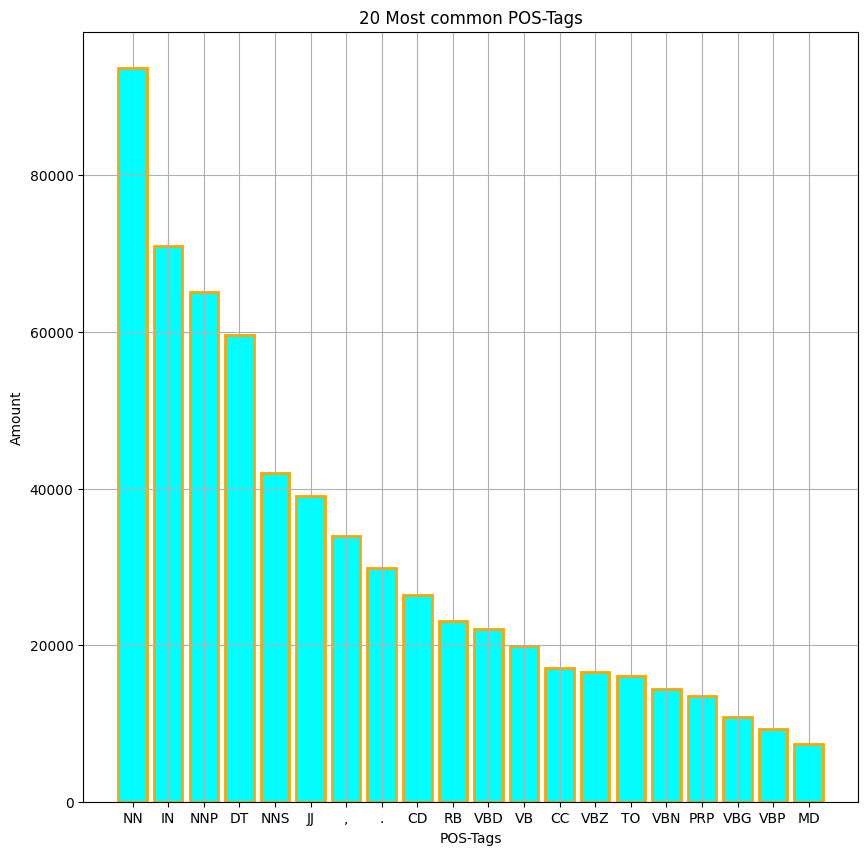

In [ ]:
# @title c3 [0pt]
import matplotlib.pyplot as plt
from collections import Counter as cnt

# retrieve the tags
all_tags = [tag for x in postags for tag in x]

print("Unique tags are: ", set(all_tags))
print("No of unique tags: ", len(set(all_tags)))
print("All tags are: ", len(all_tags))

# Count the most common ones

common_20 = cnt(all_tags).most_common(20)

# create the values of each axis

x = [tag for (tag, count) in common_20]
y = [count for (tag, count) in common_20]

# plotting section
plt.figure(1)
plt.figure(figsize=(10,10))
plt.xlabel("POS-Tags")
plt.ylabel("Amount")
plt.title("20 Most common POS-Tags")
plt.grid()
plt.bar(x, y, color ='cyan', edgecolor='orange', linewidth = 2, align ='center')

### Tensorizing sentences
Next, we need to convert our data to numeric form. Convert sentences to their tensor format, as done earlier (this may take a while).

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized with whitespace (e.g., <code>One , two , and three .</code> instead of <code>One, two, and three.</code>), we need to change the processing call to ensure the output vectors are aligned with our tokenization (otherwise SpaCy will tokenize it in its own way and might break the correspondence between tokens and POS tags).
</div>

In [ ]:
# @title c4 [0pt]
docs = list(map(
    lambda sentence: spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()),
    sentences
))

# Vector mapping
doc_vectors = map(lambda d: [w.vector for w in d], docs)
doc_tensors = list(map(lambda v: torch.tensor(np.array(v)), doc_vectors))

In [ ]:
# TEST c4
assert type(doc_tensors) == list
assert doc_tensors[0].shape == torch.Size([45, 300])
assert doc_tensors[1].shape == torch.Size([5, 300])
assert doc_tensors[2].shape == torch.Size([12, 300])

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [ ]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

print(type(pos_tensors))
print(pos_tensors[1].shape)
print(pos_tensors[1])

<class 'list'>
torch.Size([5])
tensor([12, 12, 26, 12, 14])


In [ ]:
del doc_vectors, docs, pos_numeric

In the tutorial, we saw how to split our dataset into a training and a validation set.

Do the same here, splitting the sentences, POS tags and their corresponding tensors into a training and a validation set.  
For the sake of determinism of the training, while splitting data, set shuffling `random_state` to 42 and select 0.2 of the data for validation.  

In [ ]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors, pos_tensors, test_size=0.2, random_state=42)

### Datasets and Padding

Again, following along the tutorial, we will wrap our tensors into a `Dataset` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and a `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

<div class="alert alert-block alert-info">
If you have no experience creating container-like classes from scratch in Python, refer to the documentation for the <a href="https://docs.python.org/3/reference/datamodel.html#special-method-names">special class methods</a> and for <a href="https://docs.python.org/3/reference/datamodel.html#emulating-container-types">emulating container types</a>. Talk to your teacher if needed.</div>

Then, complete the function `pad_batch` which takes a list of
(x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [ ]:
# @title c5 [.5pt]
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.X = X
        self.Y = Y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return self.X[idx], self.Y[idx]



def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:

    x_ = [m for (m,n) in batch]
    y_ = [n for (m,n) in batch]
    # apply padding to x_ and y_
    x_pad = torch.nn.utils.rnn.pad_sequence(x_)
    y_pad = torch.nn.utils.rnn.pad_sequence(y_)
    # return the padded pair
    return x_pad, y_pad

In [ ]:
# TEST c5
BATCH_SIZE = 32 # don't change this value

train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=pad_batch,
    shuffle=True, # data will be reshuffled at every epoch
    batch_size=BATCH_SIZE
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=BATCH_SIZE # don't change this value
)

What does a batch look like, shape-wise? Get the first element of `train_dataloader` to find out.  
Try to understand what each number in the shape means.  
<font color="red">_Hint_: 42 is the length of a sequence in the batch, but why 42?</font>

In [ ]:
# without the seed, every time you run this cell, it will give a random batch
torch.manual_seed(2)
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([42, 32, 300])
torch.Size([42, 32])


So far so good. On to the network.

### Utility Functions
Remember how we defined our training and validation functions in the tutorial?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor.

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you.

In [ ]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.

    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.

    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return the network's accuracy
    """
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        # note that pos tags are mapped to numbers 1..48 and we can safely use 0 for making dummy padding slots
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy in all batches.
    acc = correct/total
    return acc

In [ ]:
# If you want to understadn how accuracy works, you can verify these toy input/output pairs
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=0))
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=9))

(5, 3.0)
(8, 6.0)


Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [ ]:
# @title c6 [1pt]
# Most of the following are from the tutorial
def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer
) -> float: #batch-specific loss

    network.train()
    prediction_batch = network(X_batch)
    # tensor filled with scalar 0 values
    batch_loss = torch.zeros(1)

    for index in range(len(prediction_batch)):
        prediction = prediction_batch[index]
        batch_loss += loss_fn(prediction, Y_batch[index])

    batch_loss.backward()  # gradient computation
    optimizer.step()  # back-propagation
    optimizer.zero_grad()  # gradient reset
    #print(batch_loss.item())
    return batch_loss.item()

def train_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer,
    device: str
) -> float: #epoch's loss
    # Set the initial loss value.
    loss = 0.
    # Iterate over the batches in the dataloader.
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)  # convert back to your chosen device
        y_batch = y_batch.to(device)
        loss += train_batch(
            network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn, optimizer=optimizer
        )
    loss /= (i+1) # divide the loss by the number of batches for consistency
    return loss

# Same logic with train_batch()
def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float: #batch-specific loss
    network.eval()
    prediction_batch = network(X_batch)
    # tensor filled with scalar 0 values
    batch_loss = torch.zeros(1)

    for index in range(len(prediction_batch)):
      prediction = prediction_batch[index]
      batch_loss += loss_fn(prediction,Y_batch[index])

    #print(batch_loss.item())
    return batch_loss.item()

# Same logic as train_epoch()
def eval_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: #epoch's loss
    # Set the initial loss value.
    loss = 0.
    # Iterate over the batches in the dataloader.
    for i, (x_batch, y_batch) in enumerate(dataloader):
        # convert back to chosen device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss += eval_batch(network=network, X_batch=x_batch,
                          Y_batch=y_batch, loss_fn=loss_fn)
    loss /= (i+1) # divide the loss by the number of batches for consistency
    return loss


### SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1 due to using 0 as padding in pos tag annotations) and a pre-defined hidden size.

<ins>Use `"tanh"` as your hidden layer activation</ins>, and choose <ins>an appropriate combination of output activation and loss function</ins> (consider the task at hand and refer to the documentation or the tutorial if in doubt).

Then instantiate an optimizer over your network and train the network for a specified number of epochs, measuring and printing all four metrics at the end of each epoch: for train and validation sets, loss and accuracy values.

<font color="red">_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy. For the debugging you can try shorter hidden vectors and a single epoch.

Plot the loss and accuracy curves for the training and validation sets. Set the x-axis for epoch number and y-axis for loss/accuracy values.

In [ ]:
# @title c7.1 [.5pt]
# for deterministic initialization of weights
torch.manual_seed(0)

# Input size
INPUT_DIM = 300
# there are 48 unique tags, therefore the output is +1
OUTPUT_DIM = 49
# Hidden size definition
HIDDEN_DIM = 512
DEVICE = "cpu"

# Initialise the SRN
srn = fastSRN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM,
              hidden_activation="tanh",
              output_activation=torch.nn.LogSoftmax(dim=2),
              device=DEVICE)

# Adam Optimiser
opt = torch.optim.Adam(srn.parameters(), lr=0.003)
# Apply the loss function
loss_fn = torch.nn.NLLLoss()

In [ ]:
# @title c7.2 [1pt]
# Your training script here
# note that if you don't initialize srn from scratch, running this cell 2nd time will mean
# training the already trained parameters for further epochs
# Seed makes sure that shuffles in training set are same for each run of this cell
torch.manual_seed(0)
# Number of epochs
NUM_EPOCHS = 10

# Initialize the accuracy/loss variables
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for index in range(NUM_EPOCHS):
    train_loss_current = train_epoch(network=srn, dataloader=train_dataloader, optimizer=opt,loss_fn=loss_fn,device="cpu")
    val_loss_current = eval_epoch(network=srn, dataloader=val_dataloader, loss_fn=loss_fn, device="cpu")
    train_acc_current = measure_accuracy(network=srn, dataloader=train_dataloader, device="cpu")
    val_acc_current = measure_accuracy(network=srn, dataloader=val_dataloader, device="cpu")
    print(f"For epoch {index} the measurements are: \n\nTrain loss: {train_loss_current}"+
                       f"\nTrain accuracy: {train_acc_current}"+
                       f"\nValidation loss: {val_loss_current}"+
                       f"\nValidation accuracy: {val_acc_current}\n")
    # Add the values of each epoch for hist
    train_loss.append(train_loss_current)
    train_acc.append(train_acc_current)
    val_loss.append(val_loss_current)
    val_acc.append(val_acc_current)


For epoch 0 the measurements are: 

Train loss: 4.785408447120363
Train accuracy: 0.9506638038938436
Validation loss: 3.614697054580406
Validation accuracy: 0.9481302412180271

For epoch 1 the measurements are: 

Train loss: 3.948539184260842
Train accuracy: 0.9522848396778821
Validation loss: 3.605237777270968
Validation accuracy: 0.9488059219663811

For epoch 2 the measurements are: 

Train loss: 3.289956956825509
Train accuracy: 0.9548908085965262
Validation loss: 3.5062078023082996
Validation accuracy: 0.9503374649959835

For epoch 3 the measurements are: 

Train loss: 3.189222524971362
Train accuracy: 0.9554224486407736
Validation loss: 3.5419976257142567
Validation accuracy: 0.9505101389650072

For epoch 4 the measurements are: 

Train loss: 3.1352549066606734
Train accuracy: 0.9574128343502892
Validation loss: 3.484079077761009
Validation accuracy: 0.9529951426061757

For epoch 5 the measurements are: 

Train loss: 3.067999568206585
Train accuracy: 0.9552489661000192
Validation 

<font color="red">**Don't clear the output of the above cell!**</font>

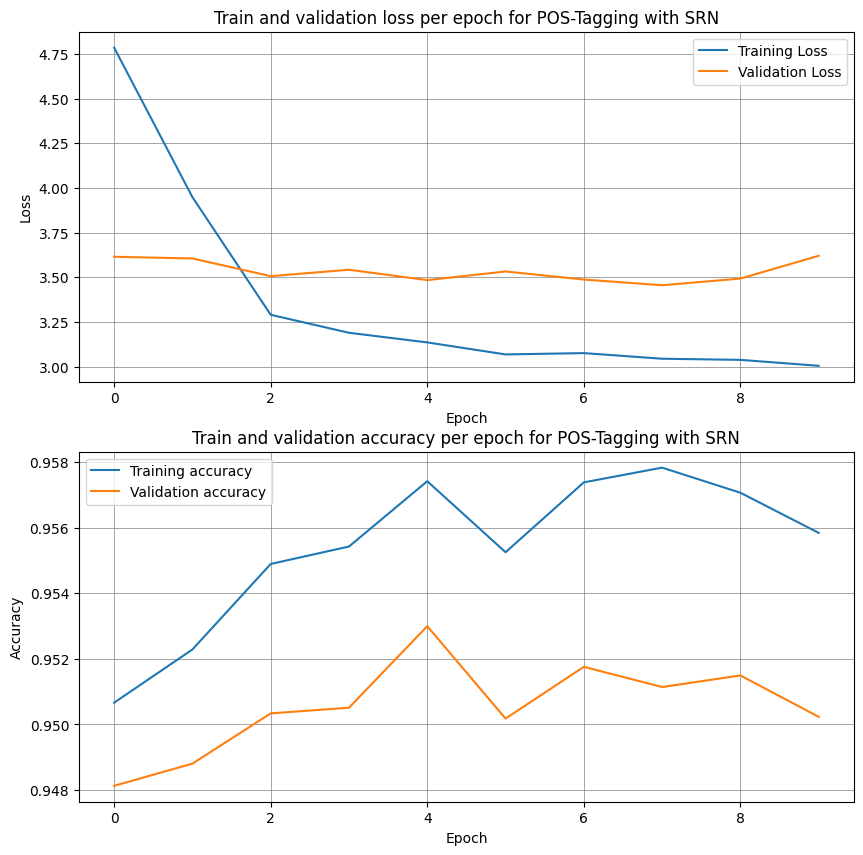

In [ ]:
# @title c7.3 [.5pt]
# Your loss plotting here: x-axis for epochs and y-axis for train and validation losses

import matplotlib.pyplot as plt
# Epoch axis
x = range(0, NUM_EPOCHS)

plt.figure(1, figsize = (10,10))
plt.subplot(2,1,1)
# plt.rcParams["figure.figsize"] = (7,7)
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Train and validation loss per epoch for POS-Tagging with SRN")\


# Your accuracy plotting here: x-axis for epochs and y-axis for train and validation accuracies
plt.subplot(2,1,2)
# plt.rcParams["figure.figsize"] = (7,7)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.title("Train and validation accuracy per epoch for POS-Tagging with SRN")
plt.show()

<font color="red">**Don't clear the output of the above cell!**</font>

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, check your code carefully.

### Error analysis
<ins>Find sentences from the validation set</ins> where the network predicted wrong POS tags.  
Complete the function that returns a list of sentences where the network failed to guess a POS tag.

In [ ]:
# @title c8 [1pt]
#   wrong_predictions(srn, sentences_val, postags_val, X_val,   Y_val,  pos_to_int, 'cpu')
def wrong_predictions(nn, sentences,        tags,     sent_vec, tag_idx, tag2idx, device='cpu'):
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag_idx: tags parameter where tags are mapped to indices
    :param tag2idx: mapping of tags to indices
    :param device: device for computation, defaults to the global DEVICE value
    returns a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    """

    # Set the model to evaluation mode
    #nn.eval()
    # List to store wrongly tagged sentences
    wrong_predictions = []
    # Some initial variables
    count = 0
    has_wrong_preds = False
    predictions = []
    predicted_tags = []
    # Exchange the keys with the values in the pos_to_int dict
    int_to_pos = {val: key for key, val in pos_to_int.items()}
    # Loop through the sentences, true tags and the sentence vector
    for sent, true_tag, sent_vector in zip(sentences, tags, sent_vec):
            # Clear the params for every loop
            wrong_predictions = []
            has_wrong_preds = False
            predicted_tags = []
            # Make predictions on the SRN
            sent_tensor = torch.tensor(sent_vector).unsqueeze(0).to(device)
            predicted_tags_idx = nn(sent_tensor)
            predicted_tags_idx = torch.argmax(predicted_tags_idx, dim=-1)

            # Identify the predicted tags
            for idx in predicted_tags_idx[0]:
                predicted_tags.append(int_to_pos.get(idx.item()))
            # Compare the true tag with the predicted tag
            for i, predicted_tag in enumerate(predicted_tags):
                if true_tag[i] != predicted_tag:
                    # Append the wrong prediction in (token, true_tag, predicted_tag) format
                    wrong_predictions.append((sent.split()[i], true_tag[i], predicted_tag))
                else:
                    # Append the correct prediction in (token, true_tag) format
                    wrong_predictions.append((sent.split()[i], true_tag[i]))
            # Loop through the wrong_predictions and ignore the sentences that have no wrong predictions
            for w_pred in wrong_predictions:
                if len(w_pred) == 3:
                    has_wrong_preds = True
            if has_wrong_preds == True: predictions.append(wrong_predictions)
    # Return the wrong predictions
    return predictions

In [ ]:
wrong_preds = wrong_predictions(srn, sentences_val, postags_val, X_val, Y_val, pos_to_int)

<ipython-input-39-88ffe20c2882>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_tensor = torch.tensor(sent_vector).unsqueeze(0).to(device)


In [ ]:
# TEST c8
for s in wrong_preds[52:55]: # feel free to change the slice indices\

    print(' '.join([ t[0] if len(t) == 2 else f"{t[0]}|{t[1]}|{t[2]}" for t in s ]))
assert len(wrong_preds)/len(sentences_val) > 0.4

Managers in all three companies recognize|VBP|VB speed as a component of quality and a key|NN|JJ to customer satisfaction .
The national office currently has 21 noncriminal audit projects , according to Marshall V. Washburn , deputy|NN|JJ assistant commissioner for examination .
Still , Hugo 's impact may revive unsuccessful proposals to give|VB|VBP local governments authority to levy|VB|NN sales|JJ|NNS taxes .


#### q8 [1pt]

Adjust the code above (in TEST cell) to make it print **three** different types of tagging mistakes you would like to discuss.  
Make suggestions as to why the mistakes were made. Refer to the [POS tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the POS tag descriptions and the [POS tag annotation guideline](https://www.cis.upenn.edu/~bies/manuals/tagguide.pdf) which defines when a particular POS tag should and should not be used.  

<font color="red">Note that we don't expect you to read the entire PDF of the guideline. Use search to find definitions of relevant POS tags and their contrast to other POS tags.

### Example 1:
**Sentence:** Managers in all three companies recognize|**VBP**|**VB** speed as a component of quality and a key|**NN**|**JJ** to customer satisfaction.

 In this example, the word "recognize" was predicted as VB (verb, base form) instead of its true tag VBP (verb, non-3rd person singular present). Although the prediction is wrong, it is possible for the word "recognize" to be tagged as VB or VBP. So the model is able to tag this word as a verb, but struggles to determine its form.
The word "key" was predicted as JJ (adjective) instead of its true tag NN (noun, singular or mass).

The context provided in the sentence might not be sufficient for the model to disambiguate the words.

### Example 2:
**Sentence:** The national office currently has 21 noncriminal audit projects, according to Marshall V. Washburn, deputy|**NN**|**JJ** assistant commissioner for examination.

In this example, the word "deputy" can be both a noun (NN) and an adjective (JJ). Without a clear context, the model might incorrectly predict its POS tag.
One reason could be that the training data lacks diverse examples of sentences with titles and roles like "deputy assistant commissioner," the model might struggle to learn the correct POS tags for such terms.

### Example 3:
**Sentence:** Still, Hugo's impact may revive unsuccessful proposals to give|**VB**|**VBP** local governments authority to levy|**VB**|**NN** sales|**JJ**|**NNS** taxes.

In this example, the word "levy" can both be a verb (VB) and a noun (NN). We believe that the reason that the model missclassified this, is the sentence form, as there are probably not many examples in the training data. Uncommon or specialized terms, such as "levy sales taxes," could pose challenges if the model hasn't encountered similar phrases in the training data. In addition, the sentence contains multiple verbs and nouns in close proximity, making it syntactically complex, and therefore, predciting a wrong tag.

### Extended error analysis

In this section we will analyze commonly confused pairs of POS tags and the reasons behind them.

Complete the function that returns details of confused pairs of POS tags. Note that the pairs are not symmetric: first one is a reference tag and another one a system-predicted tag.

<font color="red">_Hint_: In the top 5 confused pairs, there should be `JJ` occurring more than twice.  


In [ ]:
# @title c9 [.5pt]
from collections import defaultdict, Counter
def freq_confused_tags(wrongly_tagged):
    """
    :param wrongly_tagged: a list of wrongly tagged sentences. Each sentence is
        a list of tuples (tok, tag) or (tok, ref_tag, pred_tag)
    return a pair of dictionaries (can be default dict):
        dict1 is {(ref_tag, pred_tag): Counter of tokens these tags were applied to in a combination}
        dict2 is {(ref_tag, pred_tag): a dictionary {token: list of all wrongly tagged sentences where the token with given tags occur}
    """
    tag_combinations_count = defaultdict(Counter)  # {(ref_tag, pred_tag): Counter}
    tag_combinations_sentences = defaultdict(lambda: defaultdict(list))  # {(ref_tag, pred_tag): {token: list of sentences}}
    # loop through the wrongly tagged sentences
    for sentence in wrongly_tagged:
        # look through the pairs
        for token_info in sentence:
            # If (tok, ref_tag, pred_tag)
            if len(token_info) == 3:
                _, ref_tag, pred_tag = token_info
                # count the combinations
                tag_combinations_count[(ref_tag, pred_tag)][_]+= 1
                # add the sentance to the error pair
                token_dict = tag_combinations_sentences[(ref_tag, pred_tag)][_]
                token_dict.append(sentence)
    # Print the confused tag pairs
    print_confused_tag_pairs(tag_combinations_count, tag_combinations_sentences)
    return tag_combinations_count, tag_combinations_sentences

In [ ]:
# the code that prints top three confused tag pairs with the corresponding examples from the data
# this examples will be analyzed in your answer
def print_confused_tag_pairs(tag_combinations_count, tag_combinations_sentences):
    top_pairs = sorted(tag_combinations_count.items(), key=lambda x: sum(x[1].values()), reverse=True)[0:3]
    # Loop through the pairs
    for pair, count in top_pairs:
        # Print the confused pairs along with sentance examples
        ref_tag, pred_tag = pair
        print(f"Confused Tags: ({ref_tag}, {pred_tag})")
        # print("Examples:")
        # for token, sentences in tag_combinations_sentences[pair].items():
        #     print(f"Token: '{token}'")
        #     print("Sentences:")
        #     for sentence in sentences:
        #         print(" ".join(word for word, *_ in sentence))
        #     print("\n---\n")

In [ ]:
# TEST c9
confused_tags_tok_counts, confused_tags_tok_sents = freq_confused_tags(wrong_preds)

assert ("RBR", "JJR") in confused_tags_tok_counts
assert isinstance(confused_tags_tok_counts[("RBR", "JJR")], Counter)
assert "more" in confused_tags_tok_counts[("RBR", "JJR")]
assert len(confused_tags_tok_sents[("RBR", "JJR")]["more"]) == confused_tags_tok_counts[("RBR", "JJR")]["more"]
assert all([ any(["more" == t[0] for t in s]) for s in confused_tags_tok_sents[("RBR", "JJR")]["more"] ])

Confused Tags: (NNP, NN)
Confused Tags: (VB, VBP)
Confused Tags: (VBN, VBD)


#### q9 [1pt]

What are the top **three** commonly confused pairs of POS tags?

For each pair, make suggestions as to why these tag pairs are frequently confused. Refer to the examples above printed by your code.

The commonly confused taggs pairs are the following:

(NN, JJ)
(NNP, JJ)
(NN, VBG)

Certain pairs of part-of-speech (POS) tags are commonly confused due to the inherent complexities of the English language. Below we try to provide some insight on why that happens:

1. **(NN, JJ) - Token: "chief" - Noun vs. Adjective**:
**Sentence:**
*Federal Express goes further in this respect than any company I know of with both Frederick Smith and James Barksdale , **chief** executive and **chief** operating officer , respectively , sitting in on the Appeals Board almost every Tuesday to decide cases .*

Determining whether a word is a noun or an adjective often requires analyzing the surrounding context, which might not always be clear or extensive in certain sentences. This becomes even harder in this example, considering that the missclassified word occured twice in very close proximity. Also, the word "chief" as a noun and as an adjective shares similar a semantic domain.

2. **(NNP, JJ) - Token: "big" - Proper Noun vs. Adjective**:

**Sentence:**
*IBM shares closed at $ 103 , down 50 cents , in Big Board trading .*

Proper nouns can sometimes be used adjectivally to describe other nouns(like here). Determining whether a word is a proper noun or an adjective can be challenging without analyzing the broader sentence structure. In this sentence, "Big" is a proper noun functioning as an adjective, and it belongs to the (NNP, JJ) pair of tags due to its capitalized form indicating a specific name and its role as an adjective modifying the noun "Board."

3. **(NN, VBG) - Token: "mapping" -  Noun vs. Gerund (Verb Form Ending in -ing)**:

**Sentence:**
*In August , a Chicago conference on such devices attracted more than 100 researchers , who reported studies on everything from brain mapping to physical therapy .*

"Mapping" serves as a noun in this sentence, referring to a process or an act of creating maps or diagrams. But, some actions or activities represented by gerunds can be inherently noun-like (e.g., "mapping" can refer to both an action and a process), leading to ambiguity in their POS categorization.

### Congratulations!
🎉 You are done with the required part!

### Optional

RNNs have limited expressive capacity that can be surpassed by more complicated variants such as [Gated Recurrent Units](https://en.wikipedia.org/wiki/Gated_recurrent_unit) and [Long Short-Term Memory Units](https://en.wikipedia.org/wiki/Long_short-term_memory); replacing your RNN with those could easily improve the performance.

If you found the previous part easy and are already done, you can use other neural architectures to do the same task on the same dataset and compare their performance.  (There will be no support provided for this, or points, but you are welcome to explore this for your own understanding :))

Whatever your design choices are, keep the torch documentation close at all times! Do not reinvent the wheel, use existing abstractions whenever possible (but make sure you use them the right way!). Take measures against overfitting: regularize with dropout and/or weight decay and keep track of the validation set performance to stop training early if needed.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and formulation of several coding tasks in terms of functions, are by Lasha Abzianidze.